In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [3]:
df_t_1 = pd.read_csv('superposition_test/17-08-2024_17-02-45_Coil_table_data.csv', parse_dates = True, index_col=0)  #  table data
df_t_2 = pd.read_csv('superposition_test/17-08-2024_17-08-47_Coil_table_data.csv', parse_dates = True, index_col=0)  #  table data
df_t_3 = pd.read_csv('superposition_test/17-08-2024_17-14-37_Coil_table_data.csv', parse_dates = True, index_col=0)  #  table data
df_s = pd.read_csv('superposition_test/17-08-2024_17-20-10_Mangnetometer_sensor_data.csv', parse_dates = True, date_format="%d-%m-%Y_%H-%M-%S", index_col=0 )  # sensor data


df_t = pd.concat([df_t_1, df_t_2, df_t_3])

# converting index to datetime index
df_t.index = pd.to_datetime(df_t.index, format="%d-%m-%Y_%H-%M-%S")
df_s.index = pd.to_datetime(df_s.index)

# removing redundunt columns
df_t.drop(columns=['EEpose_0',	'EEpose_1',	'EEpose_2',	'EEpose_3',	'EEpose_4',	'EEpose_5',	'EEpose_6',	'EEpose_7',	'EEpose_8',	'EEpose_9',	'EEpose_10', 'EEpose_11', 'EEpose_12',	'EEpose_13', 'EEpose_14', 'EEpose_15', 'Unnamed: 89'], inplace=True)

# resampling the data for 1sec freq
df_t = df_t.resample('s').mean()
df_s = df_s.resample('s').mean()

df_t = df_t.dropna()

# join the sensor and table dataframes
df = df_t.join(df_s, how="inner")  # intersecion of the two dataframes


C:\Users\Gediy\AppData\Local\Temp\ipykernel_28432\821753528.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_t_1 = pd.read_csv('superposition_test/17-08-2024_17-02-45_Coil_table_data.csv', parse_dates = True, index_col=0)  #  table data
C:\Users\Gediy\AppData\Local\Temp\ipykernel_28432\821753528.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_t_2 = pd.read_csv('superposition_test/17-08-2024_17-08-47_Coil_table_data.csv', parse_dates = True, index_col=0)  #  table data
C:\Users\Gediy\AppData\Local\Temp\ipykernel_28432\821753528.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please sp

In [4]:
# divide the data into the three tests conducted

mask = df['cmdCoilCurrent_1(A)'] == 5
df1 = df[mask]

df1 = df1.drop(pd.Timestamp('2024-08-17 17:02:58'))

mask = df['cmdCoilCurrent_1(A)'] == 10
df2 = df[mask]

df2 = df2.drop(pd.Timestamp('2024-08-17 17:09:00'))


mask = df['cmdCoilCurrent_1(A)'] == -10
df3 = df[mask]

In [5]:
def clean_timetable(df):
    
    # Calculate the time delta between consecutive rows
    df['delta'] = df.index.to_series().diff()

    # Create a mask for rows where the time delta is greater than 1 second
    mask = df['delta'] > pd.Timedelta(seconds=2)

    specific_datetime = df.index[mask]

    # timesteps to go backwards
    time_steps = df['delta'][mask] - pd.Timedelta(seconds=2)

    # Initialize a list to accumulate new rows
    new_rows_list = []

    # Loop through each specific datetime and corresponding time step
    for dt, step in zip(specific_datetime, time_steps):
        start = dt - step
        end = dt - pd.Timedelta(seconds=1)

        # Generate a date range with the new rows
        date_range = pd.date_range(start=start, end=end, freq='s')

        # Create DataFrame with new rows
        new_rows = pd.DataFrame(index=date_range, columns=df.columns)

        # Append new rows to the list
        new_rows_list.append(new_rows)

    if (len(new_rows_list) > 0):
        # Concatenate all new rows and append them to the original DataFrame
        new_rows_combined = pd.concat(new_rows_list)
        df = pd.concat([df, new_rows_combined])

    # Sort the DataFrame by index
    df = df.sort_index()

    #########
    
    # Calculate the time delta between consecutive rows
    df['delta'] = df.index.to_series().diff()
    
    # Create a mask for rows where the time delta is greater than 1 second
    mask = df['delta'] > pd.Timedelta(seconds=1)

    # keep 3 rows preceding them
    rows_to_keep = df.index[mask].to_series().index - pd.Timedelta(seconds=3)
    
    result = df.loc[rows_to_keep]
    return result

In [6]:
df1_clean = clean_timetable(df1)
df2_clean = clean_timetable(df2)
df3_clean = clean_timetable(df3)

C:\Users\Gediy\AppData\Local\Temp\ipykernel_28432\3134449650.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_rows_combined])
C:\Users\Gediy\AppData\Local\Temp\ipykernel_28432\3134449650.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_rows_combined])
C:\Users\Gediy\AppData\Local\Temp\ipykernel_28432\3134449650.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this

In [7]:
#saving the data
df1_clean.to_csv('superposition_test/test1_measured.csv', index=True)  # index=True to include datetime index
df2_clean.to_csv('superposition_test/test2_measured.csv', index=True)  # index=True to include datetime index
df3_clean.to_csv('superposition_test/test3_measured.csv', index=True)  # index=True to include datetime index

In [37]:
def Quiver_plot(df):

    plt.style.use('_mpl-gallery')

    # Make data
    n = 4
    x = df[['Sensor_1_dir_x','Sensor_2_dir_x','Sensor_3_dir_x','Sensor_4_dir_x',
                    'Sensor_5_dir_x','Sensor_6_dir_x','Sensor_7_dir_x','Sensor_8_dir_x',
                    'Sensor_9_dir_x','Sensor_10_dir_x','Sensor_11_dir_x','Sensor_12_dir_x',
                    'Sensor_13_dir_x','Sensor_14_dir_x','Sensor_15_dir_x','Sensor_16_dir_x']].values.reshape(-1, 1)
    y = df[['Sensor_1_dir_y','Sensor_2_dir_y','Sensor_3_dir_y','Sensor_4_dir_y',
                    'Sensor_5_dir_y','Sensor_6_dir_y','Sensor_7_dir_y','Sensor_8_dir_y',
                    'Sensor_9_dir_y','Sensor_10_dir_y','Sensor_11_dir_y','Sensor_12_dir_y',
                    'Sensor_13_dir_y','Sensor_14_dir_y','Sensor_15_dir_y','Sensor_16_dir_y']].values.reshape(-1, 1)
    z = df[['Sensor_1_dir_z','Sensor_2_dir_z','Sensor_3_dir_z','Sensor_4_dir_z',
                    'Sensor_5_dir_z','Sensor_6_dir_z','Sensor_7_dir_z','Sensor_8_dir_z',
                    'Sensor_9_dir_z','Sensor_10_dir_z','Sensor_11_dir_z','Sensor_12_dir_z',
                    'Sensor_13_dir_z','Sensor_14_dir_z','Sensor_15_dir_z','Sensor_16_dir_z']].values.reshape(-1, 1)

    # X, Y, Z = np.meshgrid(x, y, z)

    U = df[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                    'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                    'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                    'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']].values.reshape(-1, 1)

    V = df[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                    'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                    'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                    'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]',]].values.reshape(-1, 1)


    W = df[['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                    'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                    'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                    'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]',]].values.reshape(-1, 1)

    # Compute the magnitude of the vectors
    magnitude = np.sqrt(U**2 + V**2 + W**2)

    # Normalize the magnitudes to the range [0, 1]
    norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

    # Create a colormap object
    colormap = cm.viridis_r  # You can choose other colormaps like 'plasma', 'inferno', etc.


    # Plot
    # Create a figure with custom size
    fig = plt.figure(figsize=(12, 8))  # Set figure size
    ax = fig.add_subplot(111, projection='3d')

    plot = ax.quiver(x, y, z, U, V, W, length=0.002, normalize= False, color=colormap(norm(magnitude)))

    # Add a colorbar to show the mapping of magnitudes to colors
    mappable = cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = plt.colorbar(mappable, ax=ax)
    cbar.set_label('Magnitude [mT]')

    ax.set(xticklabels=[],
        yticklabels=[],
        zticklabels=[],
        xlabel = ('X axis [m]'),
        ylabel = ('Y axis [m]'),
        zlabel = ('Z axis [m]'),
        title = ('Magnetic flux [mT]'))

    plt.show()

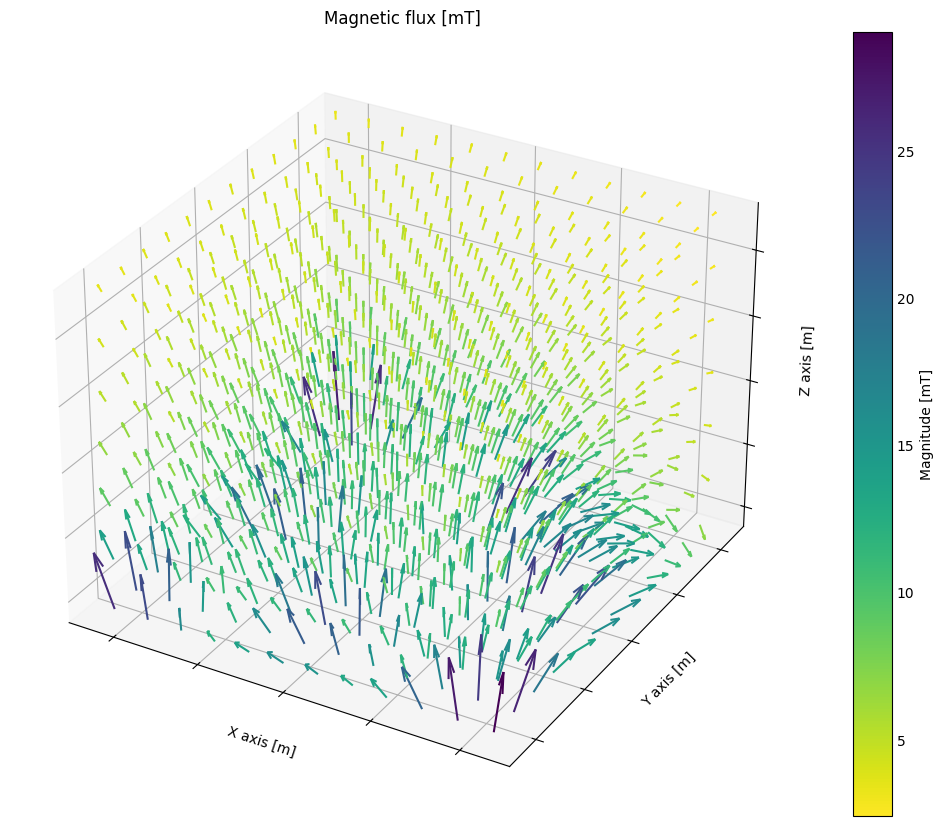

In [38]:
Quiver_plot(df1_clean)

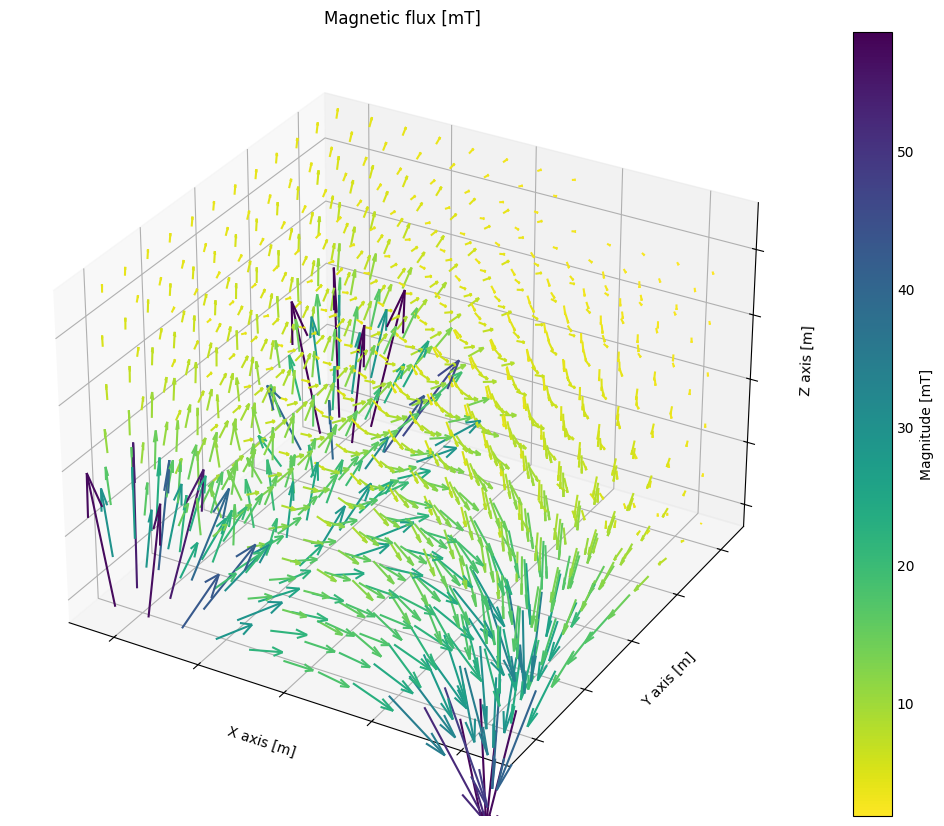

In [39]:
Quiver_plot(df2_clean)

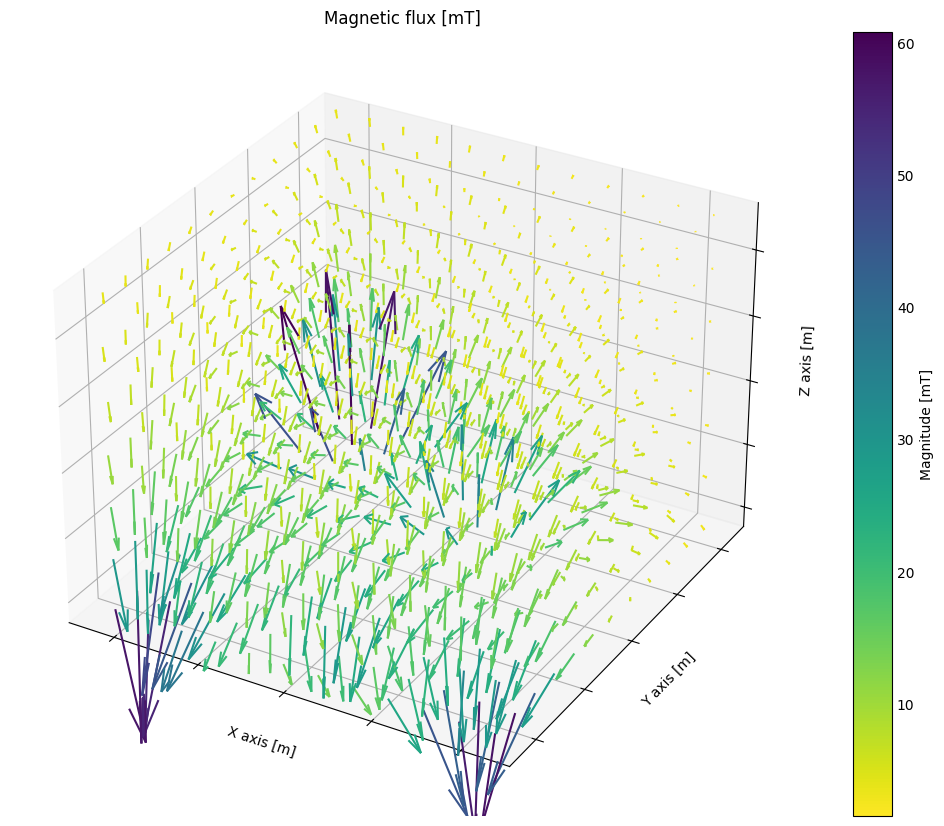

In [40]:
Quiver_plot(df3_clean)

In [11]:
def plot_Hslice(df,l):
    
    x = df[['Sensor_1_dir_x','Sensor_2_dir_x','Sensor_3_dir_x','Sensor_4_dir_x',
                    'Sensor_5_dir_x','Sensor_6_dir_x','Sensor_7_dir_x','Sensor_8_dir_x',
                    'Sensor_9_dir_x','Sensor_10_dir_x','Sensor_11_dir_x','Sensor_12_dir_x',
                    'Sensor_13_dir_x','Sensor_14_dir_x','Sensor_15_dir_x','Sensor_16_dir_x']].values.reshape(-1, 1)
    y = df[['Sensor_1_dir_y','Sensor_2_dir_y','Sensor_3_dir_y','Sensor_4_dir_y',
                    'Sensor_5_dir_y','Sensor_6_dir_y','Sensor_7_dir_y','Sensor_8_dir_y',
                    'Sensor_9_dir_y','Sensor_10_dir_y','Sensor_11_dir_y','Sensor_12_dir_y',
                    'Sensor_13_dir_y','Sensor_14_dir_y','Sensor_15_dir_y','Sensor_16_dir_y']].values.reshape(-1, 1)
    U = df[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']].values.reshape(-1, 1)

    V = df[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                    'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                    'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                    'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]']].values.reshape(-1, 1)


    
    #layer = [0 : 1*9*16], [1*9*16+1 : 2*9*16 ], [2*9*16+1 : 3*9*16], [3*9*16+1 : 4*9*16], [4*9*16+1 : 5*9*16], [5*9*16+1 : 6*9*16], [6*9*16+1 : 7*9*16]  
    i = l-1
      
    start = i*9*16
    end = l*9*16-1
      
    # Calculate magnitude for coloring
    magnitude = np.sqrt(U[start:end]**2 + V[start:end]**2)

    # Define a colormap and normalization
    norm = plt.Normalize(magnitude.min(), magnitude.max())
    # colormap = plt.cm.viridis
    colormap = plt.cm.viridis_r

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,8))

    # Create the slice plot
    slice_plot = ax.quiver(x[start:end], y[start:end], U[start:end], V[start:end], magnitude,scale=150,  cmap=colormap, norm = norm)

    

    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax, orientation='vertical')
    cbar.set_label('Magnetic flux [mT]')
    
    z = l*40

    plt.title(f'2D Slice of the magnetic field at {z} mm on the Z-axis')
    plt.xlabel('X-axis [m]')
    plt.ylabel('Y-axis [m]')
    plt.show()

In [12]:
def plot_yzslice(df,l):
    """
    PLOT ONE OF THE 12 SLICES OF Y,Z AXIS
    
    layer vlaues include the following
    
    layer= [-0.220,-0.180,-0.140,-0.100,-0.06, -0.02,0.02, 0.06, 0.1,0.14,0.18,0.22]
    """
 
    x = df[['Sensor_1_dir_x','Sensor_2_dir_x','Sensor_3_dir_x','Sensor_4_dir_x',
                    'Sensor_5_dir_x','Sensor_6_dir_x','Sensor_7_dir_x','Sensor_8_dir_x',
                    'Sensor_9_dir_x','Sensor_10_dir_x','Sensor_11_dir_x','Sensor_12_dir_x',
                    'Sensor_13_dir_x','Sensor_14_dir_x','Sensor_15_dir_x','Sensor_16_dir_x']].values.reshape(-1, 1)
    
    y = df[['Sensor_1_dir_y','Sensor_2_dir_y','Sensor_3_dir_y','Sensor_4_dir_y',
                    'Sensor_5_dir_y','Sensor_6_dir_y','Sensor_7_dir_y','Sensor_8_dir_y',
                    'Sensor_9_dir_y','Sensor_10_dir_y','Sensor_11_dir_y','Sensor_12_dir_y',
                    'Sensor_13_dir_y','Sensor_14_dir_y','Sensor_15_dir_y','Sensor_16_dir_y']].values.reshape(-1, 1)
    
    z = df[['Sensor_1_dir_z','Sensor_2_dir_z','Sensor_3_dir_z','Sensor_4_dir_z',
                    'Sensor_5_dir_z','Sensor_6_dir_z','Sensor_7_dir_z','Sensor_8_dir_z',
                    'Sensor_9_dir_z','Sensor_10_dir_z','Sensor_11_dir_z','Sensor_12_dir_z',
                    'Sensor_13_dir_z','Sensor_14_dir_z','Sensor_15_dir_z','Sensor_16_dir_z']].values.reshape(-1, 1)
    
    U = df[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']].values.reshape(-1, 1)

    V = df[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                    'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                    'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                    'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]']].values.reshape(-1, 1)
    
    W = df[['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]']].values.reshape(-1, 1)
    
    
    low = l-0.01
    high = l + 0.01

    # Create a boolean mask where values are between 'low' and 'high'
    mask = (x > low) & (x < high)

    # Get the indices of elements that satisfy the condition
    # indices = np.where(mask)[0]
      
    
      
    # Calculate magnitude for coloring
    magnitude = np.sqrt(V[mask]**2 + W[mask]**2)

    # Define a colormap and normalization
    norm = plt.Normalize(magnitude.min(), magnitude.max())
    # colormap = plt.cm.viridis
    colormap = plt.cm.viridis_r

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,8))

    # Create the slice plot
    slice_plot = ax.quiver(y[mask], z[mask], V[mask], W[mask], magnitude,scale=150,  cmap=colormap, norm = norm)

    

    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax, orientation='vertical')
    cbar.set_label('Magnetic flux [mT]')
    
    

    plt.title(f'2D Slice of the magnetic field at {l}m on the X-axis')
    plt.xlabel('Y-axis [m]')
    plt.ylabel('Z-axis [m]')
    plt.show()

In [13]:
def plot_xzslice(df,l):
    """
    PLOT ONE OF THE 12 SLICES OF Y,Z AXIS
    
    layer vlaues include the following
    
    layer= [-0.220,-0.180,-0.140,-0.100,-0.06, -0.02,0.02, 0.06, 0.1,0.14,0.18,0.22]
    """
 
    x = df[['Sensor_1_dir_x','Sensor_2_dir_x','Sensor_3_dir_x','Sensor_4_dir_x',
                    'Sensor_5_dir_x','Sensor_6_dir_x','Sensor_7_dir_x','Sensor_8_dir_x',
                    'Sensor_9_dir_x','Sensor_10_dir_x','Sensor_11_dir_x','Sensor_12_dir_x',
                    'Sensor_13_dir_x','Sensor_14_dir_x','Sensor_15_dir_x','Sensor_16_dir_x']].values.reshape(-1, 1)
    
    y = df[['Sensor_1_dir_y','Sensor_2_dir_y','Sensor_3_dir_y','Sensor_4_dir_y',
                    'Sensor_5_dir_y','Sensor_6_dir_y','Sensor_7_dir_y','Sensor_8_dir_y',
                    'Sensor_9_dir_y','Sensor_10_dir_y','Sensor_11_dir_y','Sensor_12_dir_y',
                    'Sensor_13_dir_y','Sensor_14_dir_y','Sensor_15_dir_y','Sensor_16_dir_y']].values.reshape(-1, 1)
    
    z = df[['Sensor_1_dir_z','Sensor_2_dir_z','Sensor_3_dir_z','Sensor_4_dir_z',
                    'Sensor_5_dir_z','Sensor_6_dir_z','Sensor_7_dir_z','Sensor_8_dir_z',
                    'Sensor_9_dir_z','Sensor_10_dir_z','Sensor_11_dir_z','Sensor_12_dir_z',
                    'Sensor_13_dir_z','Sensor_14_dir_z','Sensor_15_dir_z','Sensor_16_dir_z']].values.reshape(-1, 1)
    
    U = df[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']].values.reshape(-1, 1)

    V = df[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                    'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                    'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                    'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]']].values.reshape(-1, 1)
    
    W = df[['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]']].values.reshape(-1, 1)
    
    
    """
    PLOT ONE OF THE 12 SLICES OF X,Z AXIS
    
    layer vlaues include the following
    
    layer= [-0.220,-0.180,-0.140,-0.100,-0.06, -0.02,0.02, 0.06, 0.1,0.14,0.18,0.22]
    """
 
    low = l-0.01
    high = l + 0.01

    # Create a boolean mask where values are between 'low' and 'high'
    mask = (y > low) & (y < high)

    # Get the indices of elements that satisfy the condition
    # indices = np.where(mask)[0]
      
    
      
    # Calculate magnitude for coloring
    magnitude = np.sqrt(U[mask]**2 + W[mask]**2)

    # Define a colormap and normalization
    norm = plt.Normalize(magnitude.min(), magnitude.max())
    # colormap = plt.cm.viridis
    colormap = plt.cm.viridis_r

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,8))

    # Create the slice plot
    slice_plot = ax.quiver(x[mask], z[mask], U[mask], W[mask], magnitude,scale=150,  cmap=colormap, norm = norm)

    

    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax, orientation='vertical')
    cbar.set_label('Magnetic flux [mT]')
    
    

    plt.title(f'2D Slice of the magnetic field at {l}m on the Y-axis')
    plt.xlabel('X-axis [m]')
    plt.ylabel('Z-axis [m]')
    plt.show()

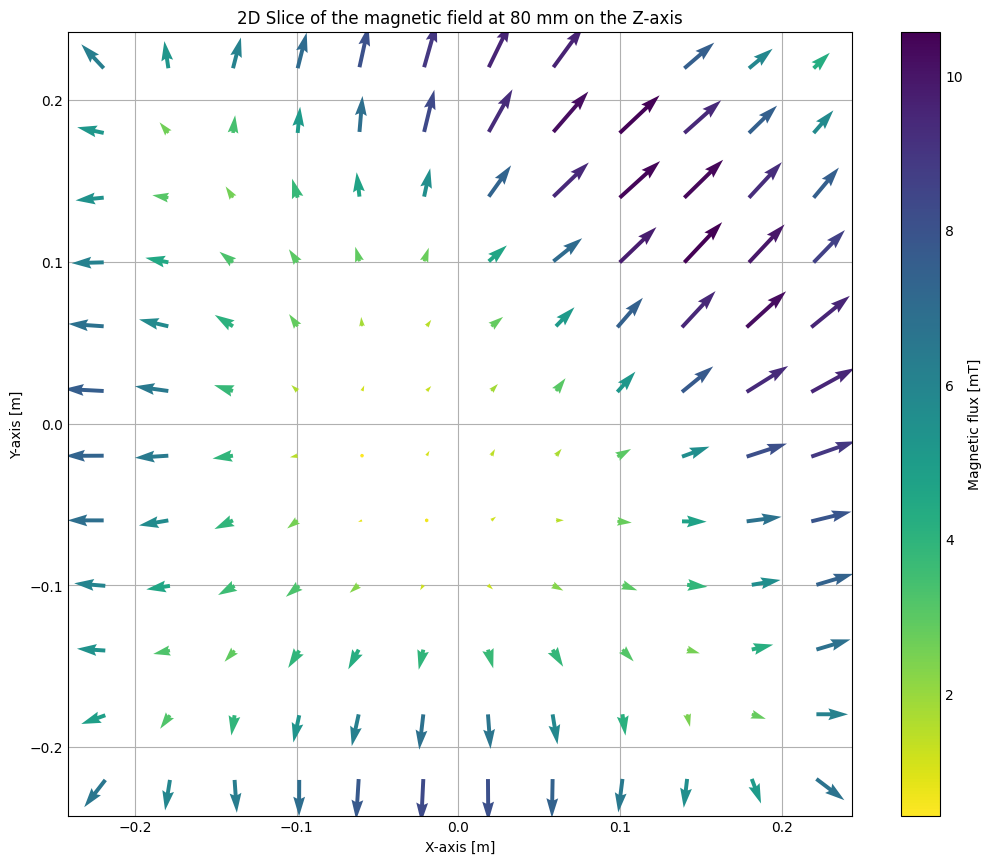

In [14]:
plot_Hslice(df1_clean,2)

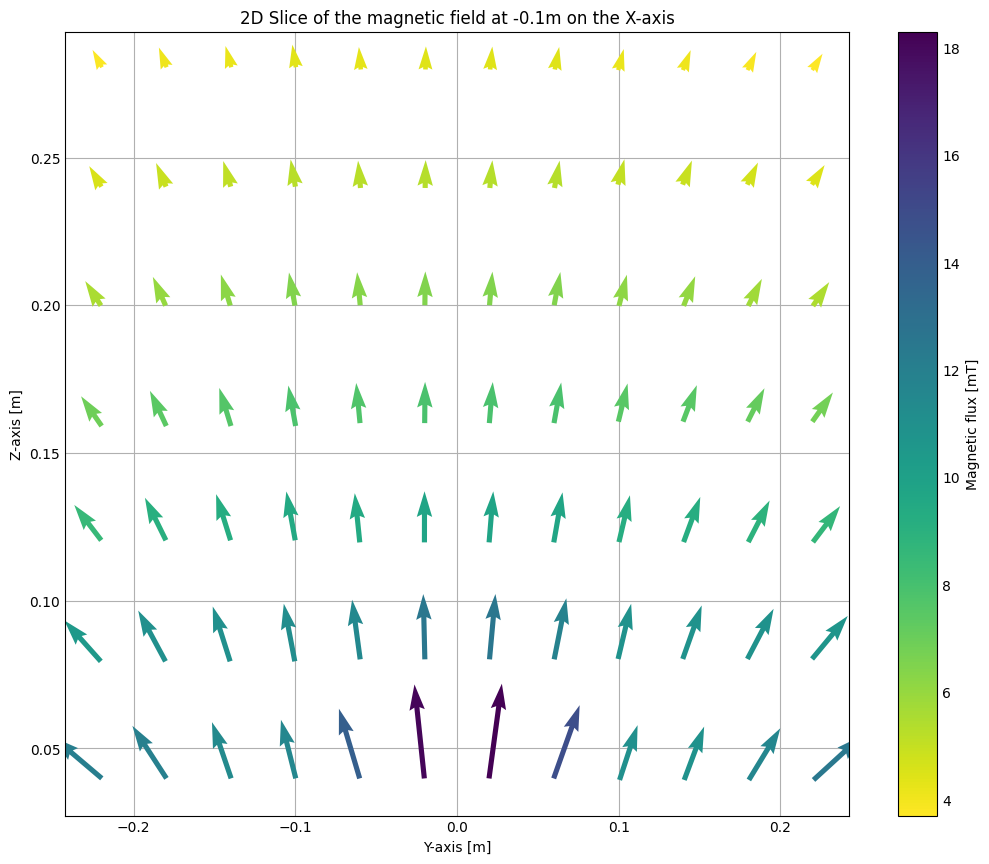

In [15]:
plot_yzslice(df1_clean,-0.1)

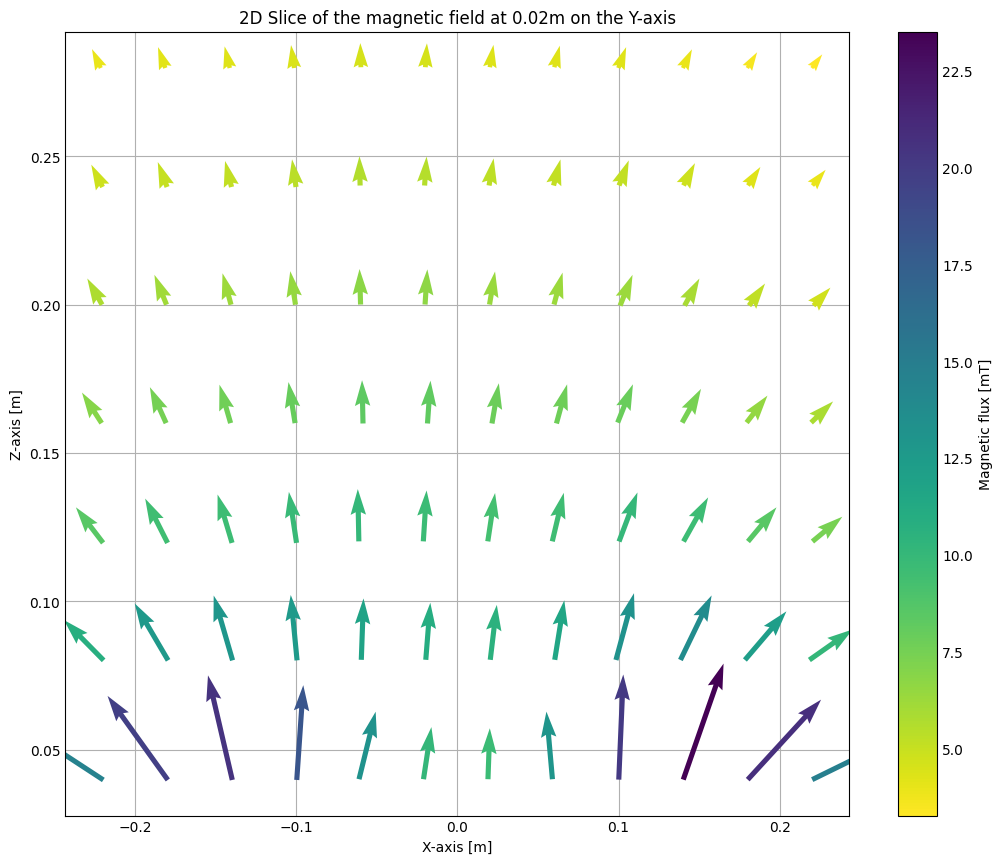

In [16]:
plot_xzslice(df1_clean,0.02)

In [41]:
C1 = pd.read_csv('Processed_data/coil1_data.csv', parse_dates = True, index_col=0)  #  Coil data
C2 = pd.read_csv('Processed_data/coil2_data.csv', parse_dates = True, index_col=0)  #  Coil data
C3 = pd.read_csv('Processed_data/coil3_data.csv', parse_dates = True, index_col=0)  #  Coil data
C4 = pd.read_csv('Processed_data/coil4_data.csv', parse_dates = True, index_col=0)  #  Coil data
C5 = pd.read_csv('Processed_data/coil5_data.csv', parse_dates = True, index_col=0)  #  Coil data

C7 = pd.read_csv('Processed_data/coil7_data.csv', parse_dates = True, index_col=0)  #  Coil data
C8 = pd.read_csv('Processed_data/coil8_data.csv', parse_dates = True, index_col=0)  #  Coil data


input_current_1 = [5,5,5,5,5,0,5,5]

input_current_2_low = [9, -1,-11,-5,5,-1,-1,9]
input_current_2_high = [11, 1,-9,-5,5,1,1,11]


input_current_3_low = [-11,-5,-11,-1,-1,-1,5,9]
input_current_3_high = [-9,-5,-9,1,1,1,5,11]


def isloate_measurement(input_current):
    #isolating the set current values
    C1_1 = C1[C1['cmdCoilCurrent_1(A)'] == input_current[0]]
    C2_1 = C2[C2['cmdCoilCurrent_2(A)'] == input_current[1]]
    C3_1 = C3[C3['cmdCoilCurrent_3(A)'] == input_current[2]]
    C4_1 = C4[C4['cmdCoilCurrent_4(A)'] == input_current[3]]
    C5_1 = C5[C5['cmdCoilCurrent_5(A)'] == input_current[4]]

    C7_1 = C7[C7['cmdCoilCurrent_7(A)'] == input_current[6]]
    C8_1 = C8[C8['cmdCoilCurrent_8(A)'] == input_current[7]]
    
    return [C1_1,C2_1,C3_1,C4_1,C5_1,C7_1,C8_1]






In [42]:
coil_data1 = isloate_measurement(input_current_1)

coil_data2_low = isloate_measurement(input_current_2_low)
coil_data2_high = isloate_measurement(input_current_2_high)

coil_data3_low = isloate_measurement(input_current_3_low)
coil_data3_high = isloate_measurement(input_current_3_high)

In [44]:
def lin_interpolate(coil_data_1, cmdCur_1, coil_data_2,cmdCur_2):
    def get_measurement_data(coil_data):
    
        U = coil_data[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                    'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                    'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                    'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']]

        V = coil_data[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                        'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                        'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                        'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]']]

        W = coil_data[['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                    'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                    'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                    'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]']]
        
        msd_coilCur = coil_data[['msdCoilCurrent_1(A)','msdCoilCurrent_2(A)','msdCoilCurrent_3(A)','msdCoilCurrent_4(A)',
                    'msdCoilCurrent_5(A)','msdCoilCurrent_6(A)','msdCoilCurrent_7(A)','msdCoilCurrent_8(A)']]
        
        msd_coilTemp = coil_data[['msdCoilTemp_1(degC)','msdCoilTemp_2(degC)','msdCoilTemp_3(degC)','msdCoilTemp_4(degC)',
                    'msdCoilTemp_5(degC)','msdCoilTemp_6(degC)','msdCoilTemp_7(degC)','msdCoilTemp_8(degC)']]
        
        
        
        return U, V, W, msd_coilCur, msd_coilTemp
    
    def set_data(coil_data, U, V, W, msd_coilCur,msd_coilTemp):
        coil_data.update(U)
        
        coil_data.update(V)
        
        coil_data.update(W)
        
        coil_data.update(msd_coilCur)
        
        coil_data.update(msd_coilTemp)
        
        return coil_data
        
        
        
    
    def interpolate(x1, x, x2, y1, y2):
        y = y2 - ((x2-x)/(x2-x1))*(y2-y1)
        return y
    
    
    interpd_list = []
    
    
    for i in range(len(coil_data_1)):
        if cmdCur_1[i] != cmdCur_2[i]:
            U1,V1,W1, msd_coilCur1, msd_coilTemp1 = get_measurement_data(coil_data_1[i])
            U2,V2,W2, msd_coilCur2, msd_coilTemp2 = get_measurement_data(coil_data_2[i])
            
            cmdCur = (cmdCur_1[i] + cmdCur_2[i])/2
            
            U = interpolate(cmdCur_1[i], cmdCur, cmdCur_2[i], U1, U2)
            V = interpolate(cmdCur_1[i], cmdCur, cmdCur_2[i], V1, V2)
            W = interpolate(cmdCur_1[i], cmdCur, cmdCur_2[i], W1, W2)
            msd_coilCur = interpolate(cmdCur_1[i], cmdCur, cmdCur_2[i], msd_coilCur1, msd_coilCur2)
            msd_coilTemp = interpolate(cmdCur_1[i], cmdCur, cmdCur_2[i],  msd_coilTemp1,  msd_coilTemp2)
            
            interpd_data = set_data(coil_data_1[i],U,V,W, msd_coilCur,msd_coilTemp )
            
            interpd_data.iloc[:,i] = cmdCur
            
            interpd_data.reset_index()      #resetting the index
            
            interpd_list.append(interpd_data)
            
                     
        else: interpd_list.append(coil_data_1[i])
        
    return interpd_list
            


In [45]:
coil_data2 = lin_interpolate(coil_data2_low, input_current_2_low, coil_data2_high, input_current_2_high)
coil_data3 = lin_interpolate(coil_data3_low, input_current_3_low, coil_data3_high, input_current_3_high)

In [46]:
# removing the top layer measurement as the robot was having issues for this case movement, measurement was not spatially accurate

coil_data2[0] = coil_data2[0].iloc[:-7]
for i in range(1,len(coil_data2)):
    coil_data2[i] = coil_data2[i].iloc[:-9]

In [48]:
def plotQuiver(x, y, z, U,V,W):
    # Compute the magnitude of the vectors
    magnitude = np.sqrt(U**2 + V**2 + W**2)

    # Normalize the magnitudes to the range [0, 1]
    norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

    # Create a colormap object
    colormap = cm.copper_r  # You can choose other colormaps like 'plasma', 'inferno', etc.


    # Plot
    # Create a figure with custom size
    fig = plt.figure(figsize=(12, 8))  # Set figure size
    ax = fig.add_subplot(111, projection='3d')

    plot = ax.quiver(x, y, z, U, V, W, length=0.002, normalize= False, color=colormap(norm(magnitude)))

    # Add a colorbar to show the mapping of magnitudes to colors
    mappable = cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = plt.colorbar(mappable, ax=ax)
    cbar.set_label('Magnitude [mT]')

    ax.set(xticklabels=[],
        yticklabels=[],
        zticklabels=[],
        xlabel = ('X axis [m]'),
        ylabel = ('Y axis [m]'),
        zlabel = ('Z axis [m]'),
        title = ('Superimposed Magnetic flux [mT]'))

    plt.show()
    
    

def superposition(list):
    
    rows =  list[0].shape[0]*16
    
    U = np.zeros((rows,1))
    V = np.zeros((rows,1))
    W = np.zeros((rows,1))

    
    for c in list:
        
        U += c[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                    'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                    'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                    'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']].values.reshape(-1, 1)

        V += c[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                        'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                        'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                        'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]']].values.reshape(-1, 1)
        
        W += c[['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                    'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                    'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                    'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]']].values.reshape(-1, 1)
        
    x = list[0][['Sensor_1_dir_x','Sensor_2_dir_x','Sensor_3_dir_x','Sensor_4_dir_x',
                'Sensor_5_dir_x','Sensor_6_dir_x','Sensor_7_dir_x','Sensor_8_dir_x',
                'Sensor_9_dir_x','Sensor_10_dir_x','Sensor_11_dir_x','Sensor_12_dir_x',
                'Sensor_13_dir_x','Sensor_14_dir_x','Sensor_15_dir_x','Sensor_16_dir_x']].values.reshape(-1, 1)
    y = list[0][['Sensor_1_dir_y','Sensor_2_dir_y','Sensor_3_dir_y','Sensor_4_dir_y',
                    'Sensor_5_dir_y','Sensor_6_dir_y','Sensor_7_dir_y','Sensor_8_dir_y',
                    'Sensor_9_dir_y','Sensor_10_dir_y','Sensor_11_dir_y','Sensor_12_dir_y',
                    'Sensor_13_dir_y','Sensor_14_dir_y','Sensor_15_dir_y','Sensor_16_dir_y']].values.reshape(-1, 1)
    z = list[0][['Sensor_1_dir_z','Sensor_2_dir_z','Sensor_3_dir_z','Sensor_4_dir_z',
                    'Sensor_5_dir_z','Sensor_6_dir_z','Sensor_7_dir_z','Sensor_8_dir_z',
                    'Sensor_9_dir_z','Sensor_10_dir_z','Sensor_11_dir_z','Sensor_12_dir_z',
                    'Sensor_13_dir_z','Sensor_14_dir_z','Sensor_15_dir_z','Sensor_16_dir_z']].values.reshape(-1, 1)
    
    plotQuiver(x,y,z,U,V,W)
        
    
    return x,y,z,U,V,W

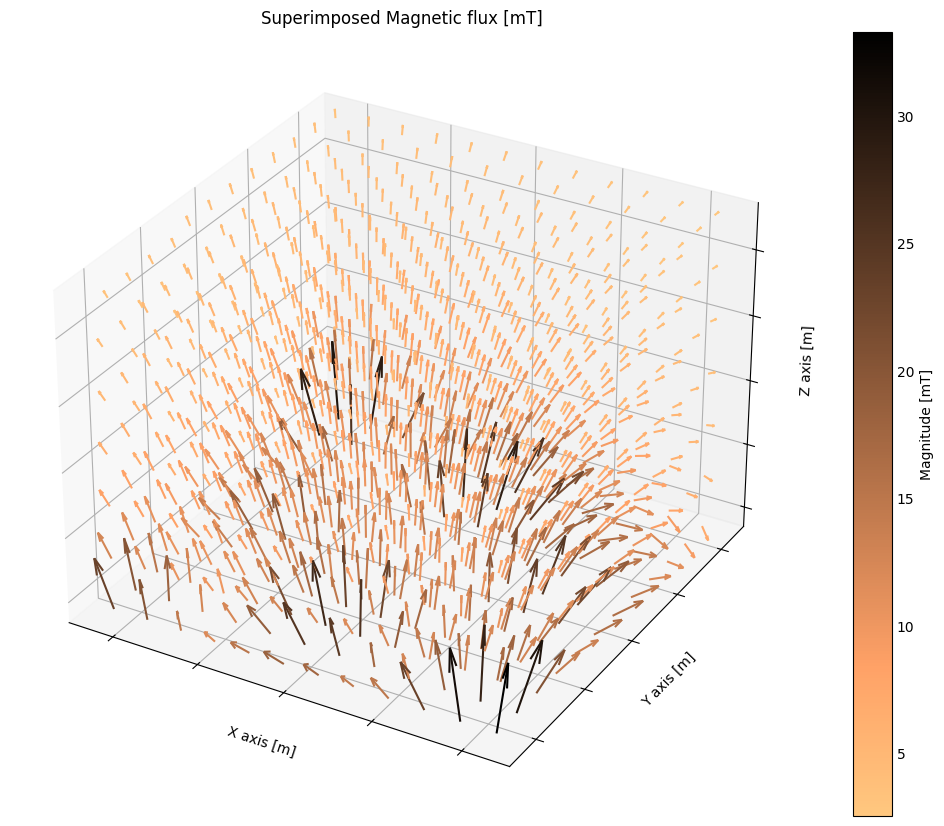

In [49]:
x1,y1,z1,U1, V1, W1 = superposition(coil_data1)

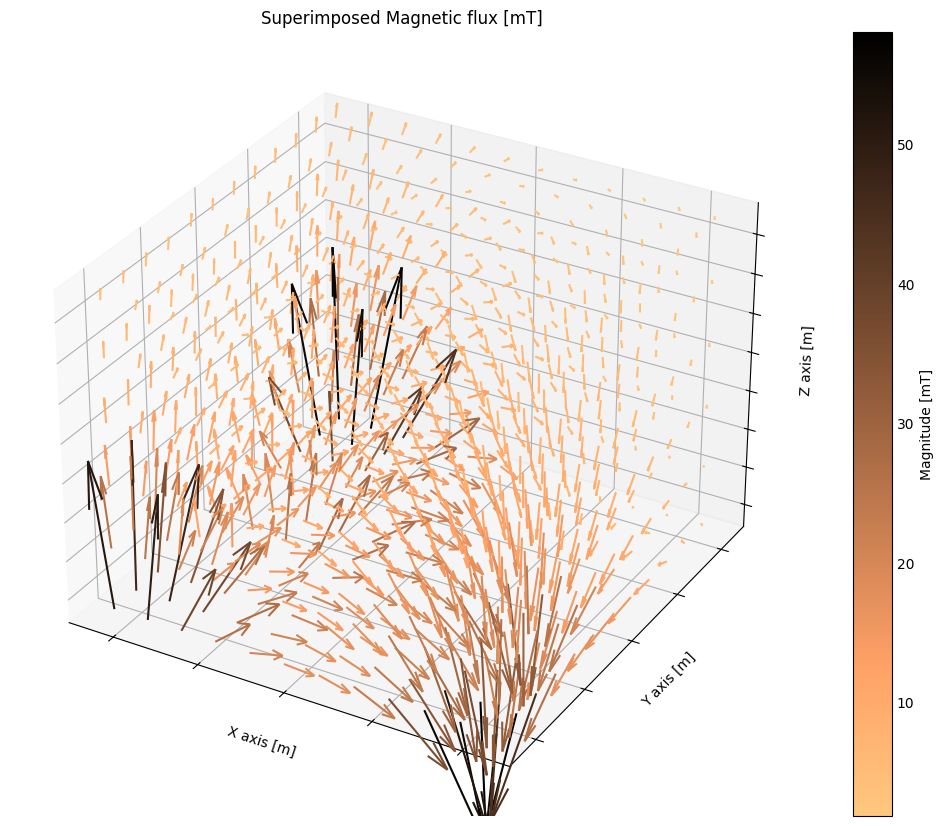

In [50]:
x2,y2,z2,U2, V2, W2 = superposition(coil_data2)

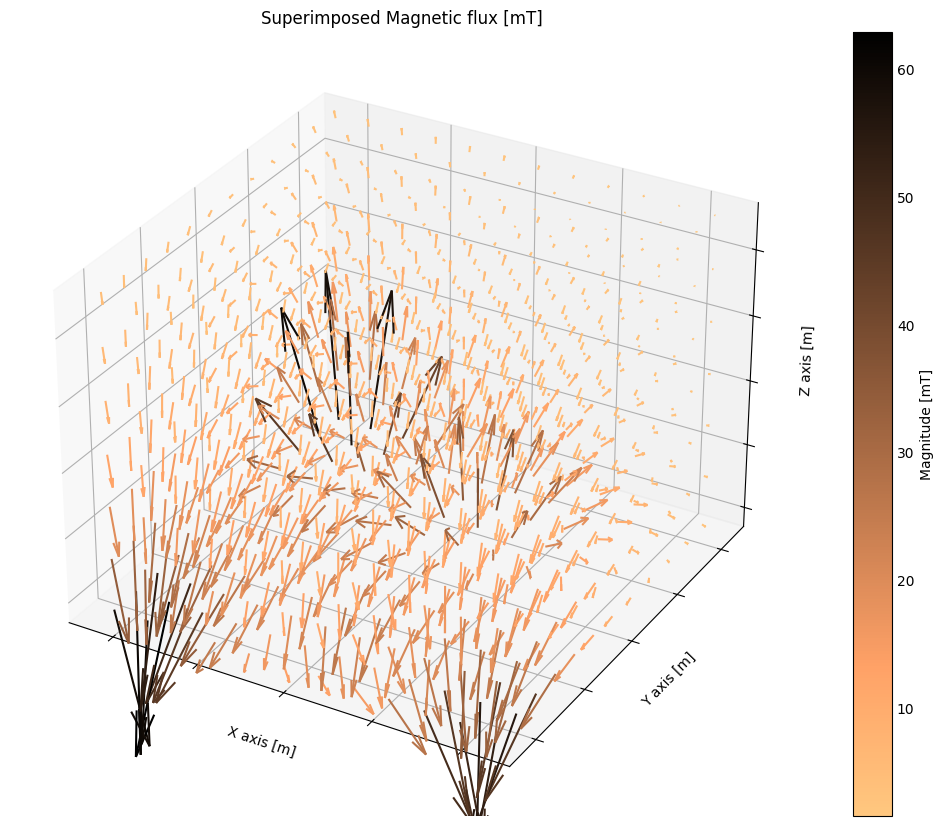

In [51]:
x3,y3,z3,U3, V3, W3 = superposition(coil_data3)

In [52]:
def Superimposed_HSlice(x1,y1,z1,U1,V1,W1, l):
    #layer = [0 : 1*9*16], [1*9*16+1 : 2*9*16 ], [2*9*16+1 : 3*9*16], [3*9*16+1 : 4*9*16], [4*9*16+1 : 5*9*16], [5*9*16+1 : 6*9*16], [6*9*16+1 : 7*9*16]  
    i = l-1
      
    start = i*9*16
    end = l*9*16-1
      
    # Calculate magnitude for coloring
    magnitude = np.sqrt(U1[start:end]**2 + V1[start:end]**2 + W1[start:end])

    # Define a colormap and normalization
    norm = plt.Normalize(magnitude.min(), magnitude.max())
    # colormap = plt.cm.viridis
    colormap = plt.cm.copper_r

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,8))

    # Create the slice plot
    slice_plot = ax.quiver(x1[start:end], y1[start:end], U1[start:end], V1[start:end], magnitude,scale=150,  cmap=colormap, norm = norm)

    

    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax, orientation='vertical')
    cbar.set_label('Magnetic flux [mT]')
    
    z = l*40

    plt.title(f'2D Slice of the magnetic field at {z} mm on the Z-axis')
    plt.xlabel('X-axis [m]')
    plt.ylabel('Y-axis [m]')
    plt.show()

In [54]:
def Superimposed_yzSlice(x1,y1,z1,U1,V1,W1, l):    
    low = l-0.01
    high = l + 0.01

    # Create a boolean mask where values are between 'low' and 'high'
    mask = (x1 > low) & (x1 < high)

    # Get the indices of elements that satisfy the condition
    # indices = np.where(mask)[0]
      

    # Calculate magnitude for coloring
    magnitude = np.sqrt(U1[mask]**2 + V1[mask]**2 + W1[mask]**2)

    # Define a colormap and normalization
    norm = plt.Normalize(magnitude.min(), magnitude.max())
    # colormap = plt.cm.viridis
    colormap = plt.cm.copper_r

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,8))

    # Create the slice plot
    slice_plot = ax.quiver(y1[mask], z1[mask], V1[mask], W1[mask], magnitude,scale=150,  cmap=colormap, norm = norm)

    

    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax, orientation='vertical')
    cbar.set_label('Magnetic flux [mT]')
    
    

    plt.title(f'2D Slice of the magnetic field at {l}m on the X-axis')
    plt.xlabel('Y-axis [m]')
    plt.ylabel('Z-axis [m]')
    plt.show()

In [55]:
def Superimposed_xzSlice(x1,y1,z1,U1,V1,W1, l):
    """
    PLOT ONE OF THE 12 SLICES OF X,Z AXIS
    
    layer vlaues include the following
    
    layer= [-0.220,-0.180,-0.140,-0.100,-0.06, -0.02,0.02, 0.06, 0.1,0.14,0.18,0.22]
    """
 
    low = l-0.01
    high = l + 0.01

    # Create a boolean mask where values are between 'low' and 'high'
    mask = (y1 > low) & (y1 < high)

    # Get the indices of elements that satisfy the condition
    # indices = np.where(mask)[0]
      
    
      
    # Calculate magnitude for coloring
    magnitude = np.sqrt(U1[mask]**2 +V1[mask]**2+ W1[mask]**2)

    # Define a colormap and normalization
    norm = plt.Normalize(magnitude.min(), magnitude.max())
    # colormap = plt.cm.viridis
    colormap = plt.cm.copper_r

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,8))

    # Create the slice plot
    slice_plot = ax.quiver(x1[mask], z1[mask], U1[mask], W1[mask], magnitude,scale=150,  cmap=colormap, norm = norm)

    

    # Add a colorbar
    cbar = plt.colorbar(slice_plot, ax=ax, orientation='vertical')
    cbar.set_label('Magnetic flux [mT]')
    
    

    plt.title(f'2D Slice of the magnetic field at {l}m on the Y-axis')
    plt.xlabel('X-axis [m]')
    plt.ylabel('Z-axis [m]')
    plt.show()

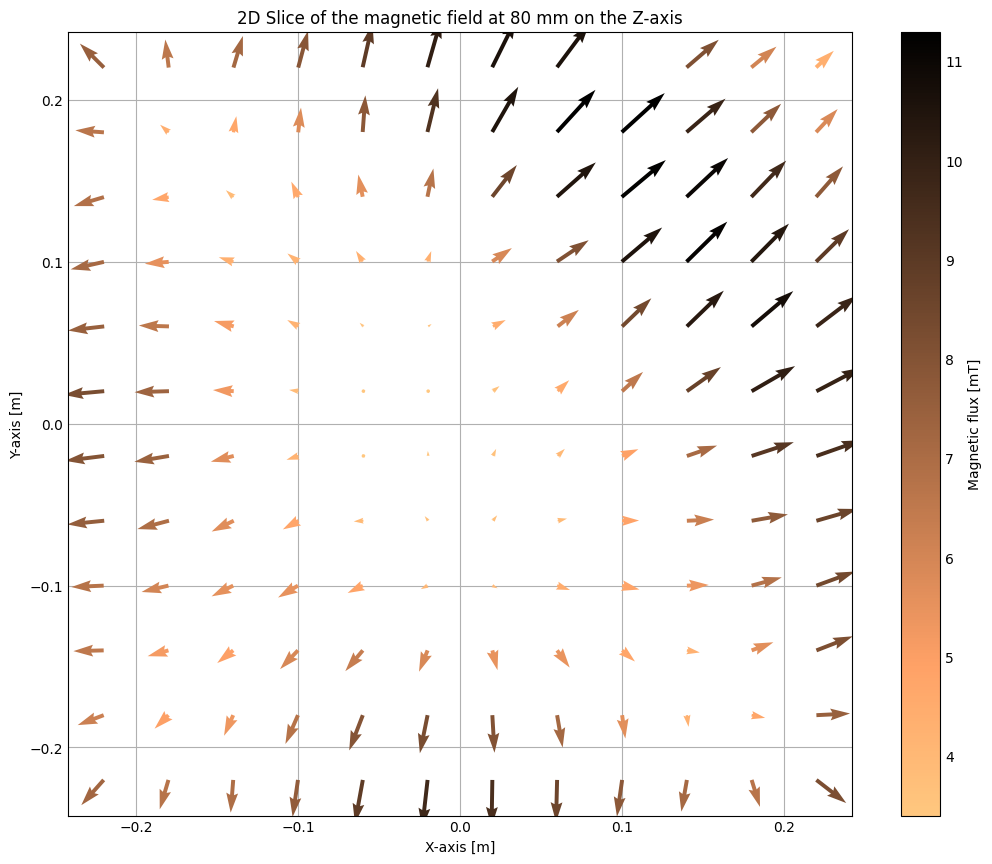

In [56]:
Superimposed_HSlice(x1,y1,z1,U1,V1,W1, 2)

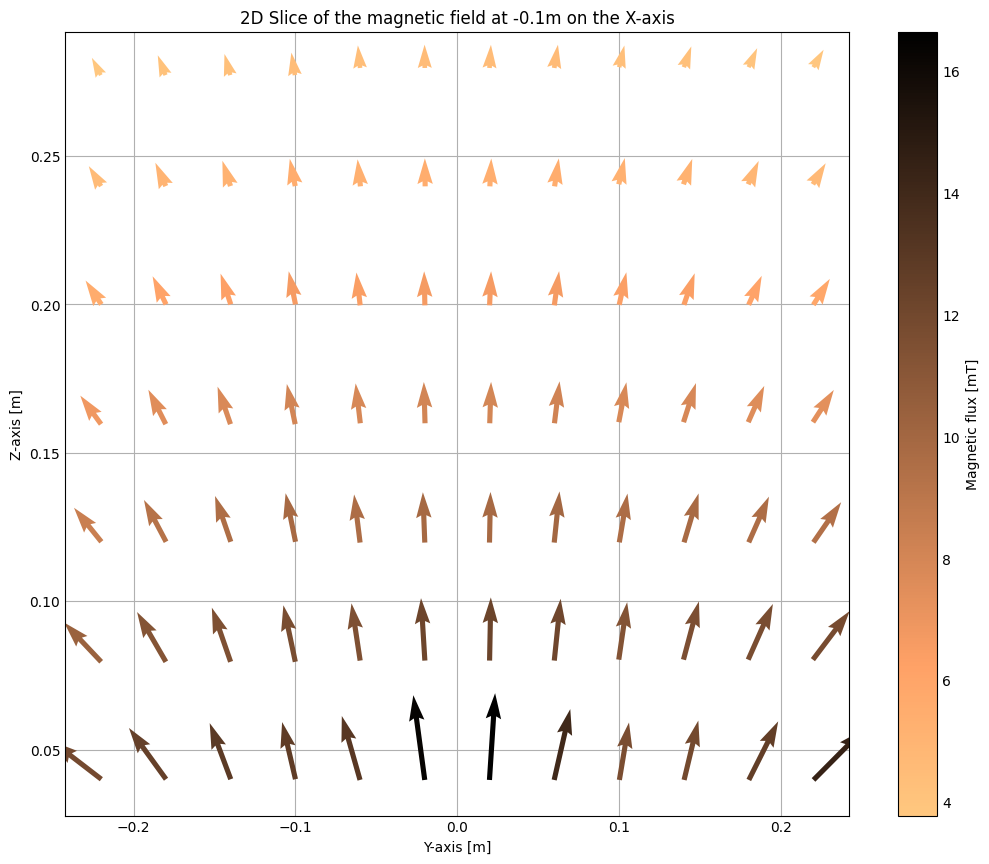

In [57]:
Superimposed_yzSlice(x1,y1,z1,U1,V1,W1, -0.1)

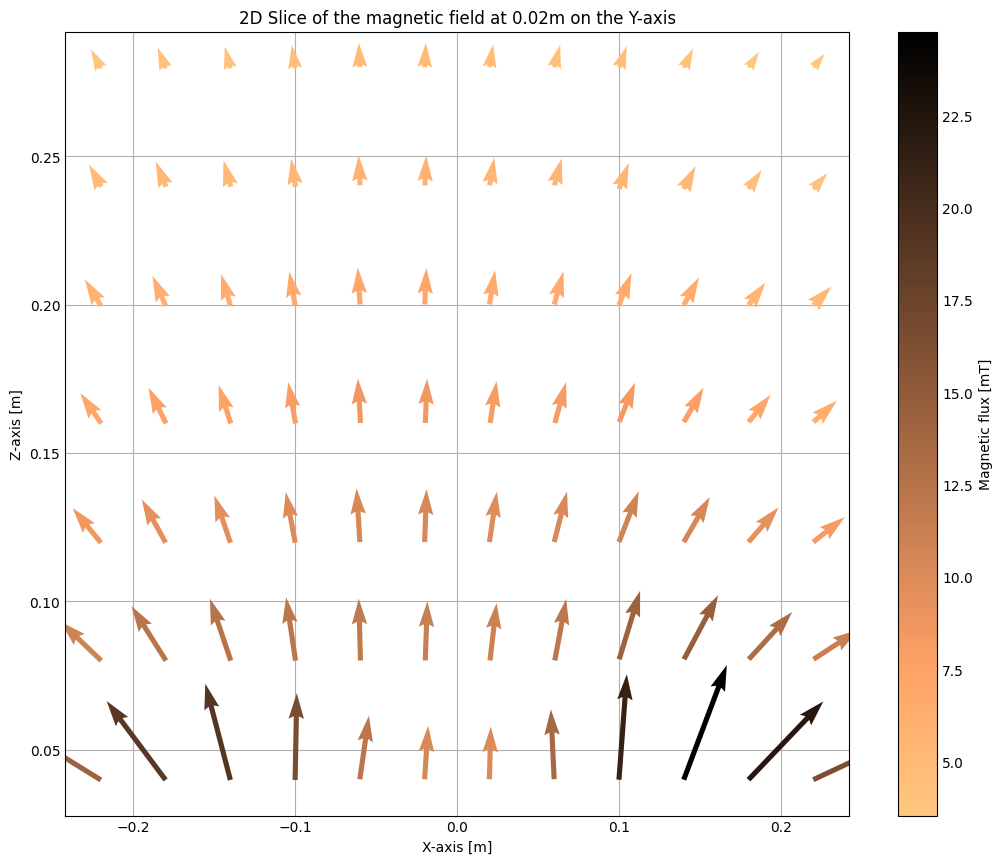

In [58]:
Superimposed_xzSlice(x1,y1,z1,U1,V1,W1,0.02)

In [59]:
def get_measurement(df):
    # checking discripancies
    U = df[['sensor_1_X [mT]','sensor_2_X [mT]','sensor_3_X [mT]','sensor_4_X [mT]',
                    'sensor_5_X [mT]','sensor_6_X [mT]','sensor_7_X [mT]','sensor_8_X [mT]',
                    'sensor_9_X [mT]','sensor_10_X [mT]','sensor_11_X [mT]','sensor_12_X [mT]',
                    'sensor_13_X [mT]','sensor_14_X [mT]','sensor_15_X [mT]','sensor_16_X [mT]']].values.reshape(-1, 1)

    V = df[['sensor_1_Y [mT]','sensor_2_Y [mT]','sensor_3_Y [mT]','sensor_4_Y [mT]',
                    'sensor_5_Y [mT]','sensor_6_Y [mT]','sensor_7_Y [mT]','sensor_8_Y [mT]',
                    'sensor_9_Y [mT]','sensor_10_Y [mT]','sensor_11_Y [mT]','sensor_12_Y [mT]',
                    'sensor_13_Y [mT]','sensor_14_Y [mT]','sensor_15_Y [mT]','sensor_16_Y [mT]',]].values.reshape(-1, 1)


    W = df[['sensor_1_Z [mT]','sensor_2_Z [mT]','sensor_3_Z [mT]','sensor_4_Z [mT]',
                    'sensor_5_Z [mT]','sensor_6_Z [mT]','sensor_7_Z [mT]','sensor_8_Z [mT]',
                    'sensor_9_Z [mT]','sensor_10_Z [mT]','sensor_11_Z [mT]','sensor_12_Z [mT]',
                    'sensor_13_Z [mT]','sensor_14_Z [mT]','sensor_15_Z [mT]','sensor_16_Z [mT]',]].values.reshape(-1, 1)
    return U,V,W
    
df2_clean = df2_clean.iloc[:-8]

U_measured_1, V_measured_1, W_measured_1 = get_measurement(df1_clean)
U_measured_2, V_measured_2, W_measured_2 = get_measurement(df2_clean)
U_measured_3, V_measured_3, W_measured_3 = get_measurement(df3_clean)




In [60]:

U_measured_1[16:32] = 0
V_measured_1[16:32] = 0
W_measured_1[16:32] = 0

U1[16:32] = 0 # Robot filed to move fully to the designated position hence the measuremen at this location is removed
V1[16:32] = 0
W1[16:32] = 0


In [1]:
def Calc_error(U_measured,V_measured,W_measured, U1, V1, W1):
    U_error = U_measured - U1
    V_error = V_measured - V1
    W_error = W_measured - W1
    
    # Orientation error

    M_measured = np.sqrt(U_measured**2 + V_measured**2 + W_measured**2)   # magnitude 
    M1 = np.sqrt(U1**2 + V1**2 + W1**2) # magnitude

    H_measured = np.sqrt(U_measured**2 + V_measured**2)   # magnitude in the horizontal plane
    H1 = np.sqrt(U1**2 + V1**2)  # magnitude in the horizontal plane

    with np.errstate(divide='ignore', invalid='ignore'):
        phi_measured = np.arcsin(np.nan_to_num(W_measured/M_measured, nan = 0, posinf=0, neginf=0))  # orientation of the magnetic field relative to the horizontal plane
        phi1 = np.arcsin(np.nan_to_num(W1/M1,nan = 0, posinf=0, neginf=0))

        theta_measured = np.arcsin(np.nan_to_num(V_measured/H_measured, nan = 0, posinf=0, neginf=0)) # orientation of the magnetic field relative to the x-axis
        theta1 = np.arcsin(np.nan_to_num(V1/H1,nan = 0, posinf=0, neginf=0))

    phi_error = phi_measured - phi1
    theta_error = theta_measured - theta1
    
    
    # mean absolute error calculation
    U_abs_error = np.mean(np.abs(U_error))
    V_abs_error = np.mean(np.abs(V_error))
    W_abs_error = np.mean(np.abs(W_error))
    M_abs_error = np.mean(np.abs(M1-M_measured))

    print('U_MAE: ', U_abs_error)
    print('V_MAE: ', V_abs_error)
    print('W_MAE: ', W_abs_error)
    print('M_MAE: ', M_abs_error)
    
    
    # Mean Absolute Percentage Error calculation
    with np.errstate(divide='ignore', invalid='ignore'): # to ignor the error prompt when dividing by zero
        U_MAPE = np.mean(np.abs(np.nan_to_num(U_error/U_measured, nan = 0, posinf=0, neginf=0))*100)
        V_MAPE = np.mean(np.abs(np.nan_to_num(V_error/V_measured, nan = 0, posinf=0, neginf=0))*100)
        W_MAPE = np.mean(np.abs(np.nan_to_num(W_error/W_measured, nan = 0, posinf=0, neginf=0))*100)
        M_MAPE = np.mean(np.abs(np.nan_to_num((M1-M_measured)/M_measured, nan = 0, posinf=0, neginf=0))*100)

    print('U_MAPE: ', U_MAPE)
    print('V_MAPE: ', V_MAPE)
    print('W_MAPE: ', W_MAPE)
    print('M_MAPE: ', M_MAPE)
    
    
    # mean absolute error for the orientaion
    phi_abs_error = np.mean(np.abs(phi_error))
    theta_abs_error = np.mean(np.abs(theta_error))

    print('phi_MAE: ', phi_abs_error, "(", np.degrees(phi_abs_error),")")
    print('theta_MAE: ', theta_abs_error, "(", np.degrees(theta_abs_error),")")
    
   

In [62]:
Calc_error(U_measured_1,V_measured_1,W_measured_1, U1, V1, W1)

U_MAE:  0.26860441468253965
V_MAE:  0.25784087301587305
W_MAE:  0.42411500330687824
M_MAE:  0.44028517006126283
U_MAPE:  42.412551621555714
V_MAPE:  106.39938075900947
W_MAPE:  6.094969160911865
M_MAPE:  4.567299864544342
phi_MAE:  0.025636830322482037 ( 1.468882177571234 )
theta_MAE:  0.08833006615760829 ( 5.060939994942299 )


In [63]:
Calc_error(U_measured_2,V_measured_2,W_measured_2, U2, V2, W2)

U_MAE:  0.5197215277777778
V_MAE:  0.46815601851851846
W_MAE:  0.921333309220679
M_MAE:  0.7734274963876053
U_MAPE:  25.15480476234996
V_MAPE:  82.54355088094863
W_MAPE:  61.371004342463884
M_MAPE:  6.896177800769674
phi_MAE:  0.0684935743248619 ( 3.924392732580204 )
theta_MAE:  0.08545332463001669 ( 4.896114846661283 )


In [64]:
Calc_error(U_measured_3,V_measured_3,W_measured_3, U3, V3, W3)

U_MAE:  0.5149885416666669
V_MAE:  0.44825302579365073
W_MAE:  0.9595039113756616
M_MAE:  0.6794199123915203
U_MAPE:  125.66842002399451
V_MAPE:  22.163715614313556
W_MAPE:  118.81045674313152
M_MAPE:  6.111626875696559
phi_MAE:  0.07897497817210307 ( 4.524932936399306 )
theta_MAE:  0.0880189347944638 ( 5.043113480959968 )
